<a href="https://colab.research.google.com/github/norayehia/Fakenewswithbert-in-nlp/blob/main/bert_of_fake2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 13.8 MB/s 
     |████████████████████████████████| 90 kB 10.1 MB/s 
     |████████████████████████████████| 132 kB 74.6 MB/s 
     |████████████████████████████████| 79 kB 9.9 MB/s 
     |████████████████████████████████| 10.3 MB 74.9 MB/s 
     |████████████████████████████████| 140 kB 81.0 MB/s 
     |████████████████████████████████| 127 kB 81.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Introduction


In this analysis, we will discuss how you can use NLP to determine whether the news is real or fake. Nowadays, fake news has become a common problem. Even respected media organizations are known to propagate fake news and are losing credibility. It can be difficult to trust news, because it can be difficult to know whether a news story is real or fake.

# Dataset
1.train.csv: A full training dataset with the following attributes                                         
2.id: unique id for a news article                                                                         
3.title: the title of a news article                                                                       
4.author: author of the news article                                                                       
5.text: the text of the article; could be incomplete                                                       
6.label: a label that marks the article as potentially unreliable. Where 0: reliable and 1: unreliable.

# Importing important libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
from pytorch_pretrained_bert import BertTokenizer, BertModel,BertAdam, BertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#from pytorch_pretrained_bert import BertTokenizer, BertConfig
#from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt


# Reading dataset

In [ ]:
train_df=pd.read_csv('/content/drive/MyDrive/research/aireserchnlp/fakenews/try2/fakdata/train.csv')
#test_df=pd.read_csv('/content/drive/MyDrive/research/aireserchnlp/fakenews/try2/fakdata/test.csv')


In [ ]:
# here we are printing first five lines of our train dataset
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# Data Pre-Processing

In [ ]:
#filling nan values with space(' ')
train_df.fillna(' ',inplace=True)

In [ ]:
#combining title and author,title and summary is formed
train_df['summary']=train_df['title']+' '+train_df['author']+' '+train_df['text']
train_df.head()

,id,title,author,text,label,summary
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [ ]:
train_df['summary'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart Daniel J. Flynn Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates

In [ ]:
train_df.isnull().sum()

id         0
title      0
author     0
text       0
label      0
summary    0
dtype: int64

In [ ]:
train_df['summary']==' '

0        False
1        False
2        False
3        False
4        False
         ...  
20795    False
20796    False
20797    False
20798    False
20799    False
Name: summary, Length: 20800, dtype: bool

**Removel of stop words and Stemming the words**

In [ ]:
# here we are importing nltk,stopwords and porterstemmer we are using stemming on the text 
# we have and stopwords will help in removing the stopwords in the text

#re is regular expressions used for identifying only words in the text and ignoring anything else
import nltk
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
ps=PorterStemmer()

In [ ]:
x=train_df['summary']
y=train_df['label']

In [ ]:
x.head()

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    FLYNN: Hillary Clinton, Big Woman on Campus - ...
2    Why the Truth Might Get You Fired Consortiumne...
3    15 Civilians Killed In Single US Airstrike Hav...
4    Iranian woman jailed for fictional unpublished...
Name: summary, dtype: object

In [ ]:
x[1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart Daniel J. Flynn Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates

#preprocessing

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# here we are creating corpus for the test dataset exactly the same as we created for the 
# training dataset
corpus=[]
for i in range(0,len(train_df)):
    review=re.sub('[^a-zA-Z]',' ',x[i])
    review=review.lower()
    review=review.split()
    review=[ps.stem(word) for word in review if not word in stopwords.words('english')]
    review=' '.join(review)
    corpus.append(review)

In [ ]:
corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn ever get feel life circl roundabout rather head straight line toward intend destin hillari clinton remain big woman campu leafi liber wellesley massachusett everywher els vote like inaugur dress remaind day way miss havisham forev wore wed dress speak great expect hillari rodham overflow year ago first address wellesley graduat class presid colleg inform gather student need debat far could ascertain spokesman kind like democrat primari minu term unknown even seven sister school glad miss adam made clear speak today us us miss rodham told classmat appoint edger bergen charli mccarthi mortim snerd attend bespectacl granni glass award matronli wisdom least john lennon wisdom took issu previou speaker despit becom first win elect seat u senat sinc reconstruct edward brook came critic call empathi goal protestor critic tactic though clinton senior thesi saul alinski lament black power demagogu elitist arrog repress intoler with

In [ ]:
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in corpus]
labels = train_df['label']

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 906937.95B/s]


Tokenize the first sentence:
['[CLS]', 'ho', '##us', 'dem', 'aid', 'even', 'see', 'come', '##y', 'letter', 'jason', 'cha', '##ffe', '##tz', 't', '##wee', '##t', 'dar', '##rel', 'luc', '##u', 'ho', '##us', 'dem', 'aid', 'even', 'see', 'come', '##y', 'letter', 'jason', 'cha', '##ffe', '##tz', 't', '##wee', '##t', 'dar', '##rel', 'luc', '##u', 'oct', '##ob', 'sub', '##sc', '##ri', '##b', 'jason', 'cha', '##ffe', '##tz', 'stump', 'american', 'fork', 'utah', 'im', '##ag', 'court', '##es', '##i', 'michael', 'jo', '##lley', 'avail', 'cr', '##ea', '##tiv', 'common', 'li', '##cens', 'ap', '##olo', '##g', 'keith', 'ol', '##berman', '##n', 'doubt', 'worst', 'person', 'world', 'week', 'fbi', 'director', 'jam', '##e', 'come', '##y', 'accord', 'ho', '##us', 'democrat', 'aid', 'look', 'like', 'also', 'know', 'second', 'worst', 'person', 'well', 'turn', 'come', '##y', 'sent', 'in', '##fa', '##m', 'letter', 'ann', '##oun', '##c', 'fbi', 'look', 'email', 'may', 're', '##lat', 'hill', '##ari', 'clinton',

In [ ]:
len(tokenized_texts[0])

689

In [ ]:

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [ ]:

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# 3Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# 4Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:

# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)


<ipython-input-39-26ef1eedc5bd>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)


In [ ]:
validation_inputs = torch.tensor(validation_inputs)

<ipython-input-40-08e540e74da3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_inputs)


In [ ]:
train_masks = torch.tensor(train_masks)

In [ ]:
validation_masks = torch.tensor(validation_masks)

In [ ]:
validation_labels = torch.tensor(validation_labels.to_numpy())

In [ ]:
train_labels = torch.tensor(train_labels.to_numpy())

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:13<00:00, 29426275.85B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
     

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.26752843900114043


Epoch:  25%|██▌       | 1/4 [08:01<24:05, 481.82s/it]

Validation Accuracy: 0.9360576923076923
Train loss: 0.21939350126518142


Epoch:  50%|█████     | 2/4 [16:02<16:02, 481.32s/it]

Validation Accuracy: 0.9370192307692308
Train loss: 0.207763537665845


Epoch:  75%|███████▌  | 3/4 [24:02<08:00, 480.66s/it]

Validation Accuracy: 0.9668269230769231
Train loss: 0.08604565399189472


Epoch: 100%|██████████| 4/4 [32:02<00:00, 480.67s/it]

Validation Accuracy: 0.9884615384615385


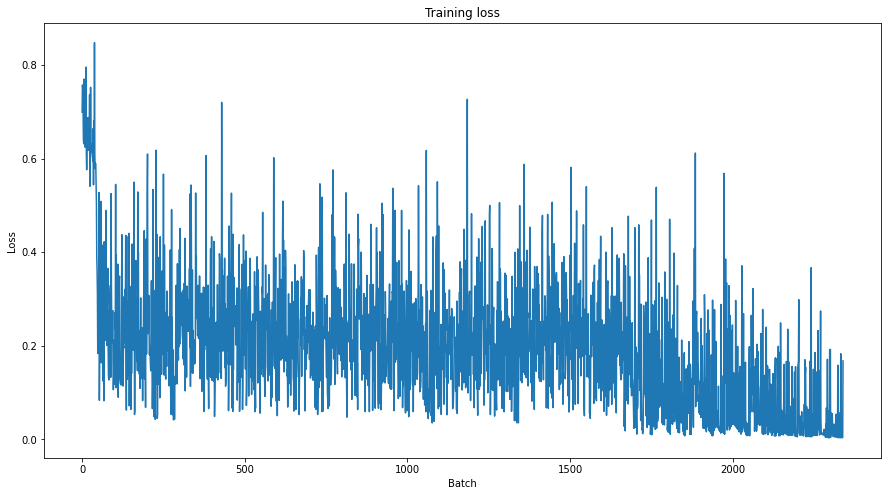

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()